# Notebook Setup

In [ ]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling"

## Import Modules

In [ ]:
import os
os.chdir(MY_HOME_ABS_PATH)

import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters, MetricsCallback
from pytorch_forecasting import BaseModel, MAE
# from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback

# from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib_for_nbinstance import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

In [ ]:
# data/models/tft_model_1yrtrain_tuning_230318_1906/trial_0/epoch=12.ckpt

## Define Local File System Constants

In [ ]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

# Load Train and Test dataset from Azure Storage Blob

In [ ]:
azStorageClient.listBlobs(container_name)

In [ ]:
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

local_file = tmp_dir + os.sep + blob_name

In [ ]:
# def get_raw_datasets(container, blob_name):
local_file = tmp_dir + os.sep + blob_name
data_df = None
if not (os.path.exists(local_file)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
    data_df = pd.read_parquet(file_stream, engine='pyarrow')
    data_df.to_parquet(local_file)
else:
    data_df = pd.read_parquet(local_file)

print(f"Data size: {data_df.shape}")

# Convert Dtypes
cat_cols = ["year", "month", "day", "hour", "MODIS_IGBP", "koppen_main", "koppen_sub", 
            "gap_flag_month", "gap_flag_hour"]
for col in cat_cols:
    data_df[col] = data_df[col].astype(str).astype("category")

print(f"Data Columns: {data_df.columns}")
print(f"NA count: {data_df.isna().sum().sum()}")
# return data_df

# Load Three Best Models As of April 8

In [ ]:
!pwd
model_dir
MY_HOME_ABS_PATH

In [ ]:
best_model_path_GPP = f"{MY_HOME_ABS_PATH}/data/models/tft_model_1yrtrain_tuning_230318_1906/trial_0/epoch=12.ckpt"
# best_model_path_NO_GPP: 
# full: 
# slim: Gain from "tft_model_15_tft_nogpp_small_lr_230405_0227"
# best_model_path_TreeFT = f"{model_dir}tft_model_1YrTrain_3DEncode_RFRGPP_230329_0107/lightning_logs/version_0/checkpoints/epoch=8-step=11907.ckpt"

In [ ]:
best_GPP = TemporalFusionTransformer.load_from_checkpoint(best_model_path_GPP)
# best_NO_GPP = TemporalFusionTransformer.load_from_checkpoint(best_model_path_NO_GPP)
# best_TreeFT = TemporalFusionTransformer.load_from_checkpoint(best_model_path_TreeFT)
print(f"Quantiles: {best_GPP.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# print(f"Quantiles: {best_NO_GPP.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# print(f"Quantiles: {best_TreeFT.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Make prediction for three best models

### Define TS Dataset(two types)

In [ ]:
# Use this instead!!
def setup_tsdataset(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [ ]:
# Use this instead!!


def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


# setup datasets data
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
training, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)

Setup batch size

In [ ]:
# create dataloaders for model
batch_size = 64
cpu_count = os.cpu_count()

## Create TS Dataset

In [ ]:
# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365 # 1 year
ENCODER_LEN =  24*7
print(f"training timestemp length= {SUBSET_LEN}")

# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)

### GPP-TFT

In [ ]:
(training_GPP, validation_GPP, testing_GPP) = setup_tsdataset(train_df, val_df, test_df, ENCODER_LEN)

In [ ]:
# # Get small test data
# subtest_df = test_df.loc[test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
# _, _, subtesting = setup_tsdataset(train_df, val_df, subtest_df, ENCODER_LEN)
# print(f"Subset num subtest timesteps: {len(subtest_df)}")

# # create dataloaders for model
# # ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
# batch_size = 64  # set this between 32 to 128
# cpu_count = os.cpu_count()

### Define TS Dataset for NO-PAST-GPP models

In [ ]:
# (training_NO_PAST_GPP, validation_NO_PAST_GPP, testing_NO_PAST_GPP) = setup_tsdataset_no_past_GPP(train_df, val_df, test_df, ENCODER_LEN)


In [ ]:
# # Get small test data
# subtest_df = test_df.loc[test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
# _, _, subtesting = setup_tsdataset(train_df, val_df, subtest_df, ENCODER_LEN)
# print(f"Subset num subtest timesteps: {len(subtest_df)}")

# # create dataloaders for model
# # ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
# batch_size = 64  # set this between 32 to 128
# cpu_count = os.cpu_count()

In [ ]:
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=cpu_count, pin_memory=True)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count, pin_memory=False)

# # Create TFT model from dataset
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.00001,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     attention_head_size=1, # Set to up to 4 for large datasets
#     dropout=0.3, # Between 0.1 and 0.3 are good values
#     hidden_continuous_size=16,  # set to <= hidden_size
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     logging_metrics=nn.ModuleList([MAE(), RMSE()]),
#     reduce_on_plateau_patience=2, # reduce learning rate if no improvement in validation loss after x epochs
#     optimizer="adam"
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=6, mode="min", check_finite=True, verbose=False,)
# lr_logger = LearningRateMonitor()  # log the learning rate
# checkpoint_callback = ModelCheckpoint(dirpath=exp_model_dir, save_top_k=3, monitor="val_loss") # save model objects for top k epoch val loss
# logger = TensorBoardLogger(exp_model_dir)  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=25,
#     enable_model_summary=True,
#     #gradient_clip_val=2,
#     fast_dev_run=False, 
#     accelerator='gpu',
#     devices="auto", 
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
#     strategy="ddp",
# )

## Prepare Two Validation Data Loaders

In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
# Eval on Validation set
val_dataloader_GPP = validation_GPP.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
val_actuals_GPP = torch.cat([y[0] for x, y in iter(val_dataloader_GPP)])

In [ ]:
# Eval on Validation set
val_dataloader_GPP = validation_GPP.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader_GPP)])



In [ ]:
# save eval results - also we can resume eval at a later point in time

with open("val_actuals_best_GPP_TFT_April8.pkl", "wb") as fout:
    pickle.dump(val_actuals_GPP, fout)

In [49]:
!pwd

/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling


In [51]:
import boto3
import json
from io import StringIO
# create an S3 client
# s3_client = boto3.client('s3')

# bucket_name = 'rumi-store-prediction-result'
# file_name = "val_actuals_best_GPP_TFT_April8.pkl"

# # upload the file to S3
# s3_client.upload_file(file_name, bucket_name,
#                       "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling")

In [53]:
# create a large dictionary
# my_dict = {...}  # your large dictionary here

# serialize the dictionary to a JSON-formatted string
# json_string = json.dumps(my_dict)

# # create a StringIO buffer to hold the JSON string in memory
# buffer = StringIO(json_string)

# # upload the buffer to S3
# bucket_name = 'your-bucket-name'
# file_name = 'your-file-name.json'
# s3_client.put_object(Body=buffer.getvalue(), Bucket=bucket_name, Key=file_name)

# Prediction on three best models

## Best GPP

In [56]:
# print(f"Start eval on validation.")
# start = default_timer()
# val_raw_pred_GPP, val_x_GPP = best_GPP.predict(val_dataloader_GPP, mode="raw", show_progress_bar=True, return_x=True)
# eval_time = default_timer() - start
# print(f"Val eval time: {eval_time}")

In [58]:
# Store raw_predictions
# val_raw_predictions_store = {}
# for i in val_raw_pred_GPP.keys():
#     val_raw_predictions_store[i] = val_raw_pred_GPP[i]

# with open('val_raw_predictions_best_GPP_april8.pkl', 'wb') as handle:
#     pickle.dump(val_raw_predictions_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
# # open pickle from storage
# with open('val_raw_predictions_best_GPP_april8.pkl', 'rb') as handle:
#     raw_predictions_GPP = pickle.load(handle)

# print(raw_predictions_GPP.keys())

In [59]:
# # Store x
# val_x_store = {}
# for i in val_x_GPP.keys():
#   val_x_store[i] = val_x_GPP[i]

# with open('val_x_best_GPP_april4.pkl', 'wb') as handle:
#     pickle.dump(val_x_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('val_x_best_GPP_april4.pkl', 'rb') as handle:
#     x_GPP = pickle.load(handle)

# print(x_GPP.keys())

## Access raw predictions and x via Azure

In [ ]:
container_name = "model-eval"
blob_name = "val_x_best_GPP_TFT_april4" 

# def get_raw_datasets(container, blob_name):
val_x = None

container_name = 'model-eval'
blob_name_list = azStorageClient.listBlobs(container_name)
for i, blob in enumerate(blob_name_list):
    print(f'{i:3} {blob.name}')
    if i > 4:
        break

# # if not (os.path.exists(local_file)):
# azStorageClient = AzStorageClient(az_cred_file)
# file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
# val_x_best_GPP_TFT = pd.read_pickle(file_stream, engine='pyarrow')
#     # data_df.to_parquet(local_file)
# # # else:
# #     data_df = pd.read_parquet(local_file)

In [ ]:
file_stream = azStorageClient.downloadBlob2Stream(container_name, 'val_x_best_GPP_TFT_april4.pkl')



In [101]:
val_x_best_GPP_TFT = pd.read_pickle(file_stream)

EOFError: Ran out of input

In [ ]:
file_stream.seek(0)    # move back to the beginning after writing
old_list = pickle.load(file_stream)

In [ ]:
container_name = "model-eval"
blob_name = "val_raw_predictions_best_GPP_TFT_april4" 

## NO-GPP

In [ ]:
 best_NO_GPP

TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.4
  	"embedding_labels":                  {'MODIS_IGBP': {'nan': 0, 'CRO': 1, 'CSH': 2, 'DBF': 3, 'EBF': 4, 'ENF': 5, 'GRA': 6, 'MF': 7, 'OSH': 8, 'SAV': 9, 'URB': 10, 'WAT': 11, 'WSA': 12}, 'koppen_main': {'nan': 0, '1': 1, '2': 2, '3': 3, '4': 4}, 'month': {'1': 0, '10': 1, '11': 2, '12': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}, 'hour': {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23}, 'gap_flag_month': {'0.0': 0, '1.0': 1}, 'gap_flag_hour': {'0.0': 0, '1.0': 1}}
  	"embedding_paddings":                ['MODIS_IGBP', 'koppen_main']
  	"embedding_sizes":                   {'MODIS_IGBP': (13, 

In [ ]:
print(f"Start eval on validation.")
start = default_timer()
val_raw_pred_NO_GPP, val_x_NO_GPP = best_NO_GPP.predict(val_dataloader, mode="raw", show_progress_bar=True, return_x=True)
eval_time = default_timer() - start
print(f"Val eval time: {eval_time}")

Start eval on validation.


Predict:   0%|          | 0/3491 [00:00<?, ? batches/s]

IndexError: ignored

In [ ]:
# Store raw_predictions
val_raw_predictions_store = {}
for i in val_raw_pred_NO_GPP.keys():
  val_raw_predictions_store[i] = val_raw_pred_NO_GPP[i]

with open('val_raw_predictions_best_NO_GPP_april4.pkl', 'wb') as handle:
    pickle.dump(val_raw_predictions_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
# open pickle from storage
with open('val_raw_predictions_best_NO_GPP_april4.pkl', 'rb') as handle:
    raw_predictions_NO_GPP = pickle.load(handle)

print(raw_predictions_NO_GPP.keys())

In [ ]:
# Store x
val_x_store = {}
for i in val_x_NO_GPP.keys():
  val_x_store[i] = val_x_NO_GPP[i]

with open('val_x_best_NO_GPP_april4.pkl', 'wb') as handle:
    pickle.dump(val_x_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('val_x_best_NO_GPP_april4.pkl', 'rb') as handle:
    x_NO_GPP = pickle.load(handle)

print(x_NO_GPP.keys())

## TreeFT

In [ ]:
print(f"Start eval on validation.")
start = default_timer()
val_raw_pred_TreeFT, val_x_TreeFT = best_TreeFT.predict(val_dataloader, mode="raw", show_progress_bar=True, return_x=True)
eval_time = default_timer() - start
print(f"Val eval time: {eval_time}")

Start eval on validation.


Predict:   0%|          | 0/3491 [00:00<?, ? batches/s]

IndexError: ignored

In [ ]:
# Store raw_predictions
val_raw_predictions_store = {}
for i in val_raw_pred_TreeFT.keys():
  val_raw_predictions_store[i] = val_raw_pred_TreeFT[i]

with open('val_raw_predictions_best_TreeFT_april4.pkl', 'wb') as handle:
    pickle.dump(val_raw_predictions_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
# open pickle from storage
with open('val_raw_predictions_best_TreeFT_april4.pkl', 'rb') as handle:
    raw_predictions_TreeFT = pickle.load(handle)

print(raw_predictions_TreeFT.keys())

In [ ]:
# Store x
val_x_store = {}
for i in val_x_TreeFT.keys():
  val_x_store[i] = val_x_TreeFT[i]

with open('val_x_best_TreeFT_april4.pkl', 'wb') as handle:
    pickle.dump(val_x_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('val_x_best_TreeFT_april4.pkl', 'rb') as handle:
    x_TreeFT = pickle.load(handle)

print(x_TreeFT.keys())

# Analyze Features

In [ ]:
def get_eval_metrics_simple(y_true, y_pred, mask=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
    mae = torch.mean((y_true - y_pred).abs()).item()
    nse = nash_sutcliffe(y_true, y_pred).item()
    
    return rmse, mae, nse

def eval_raw_preds(raw_preds, val_dl):
    # Format val_preds
    val_preds = raw_preds['prediction'][:, :, 3]
    
    # Get actuals and mask from val_dl
    val_actuals_list = []
    mask_list = []
    for x, y in iter(val_dl):
        val_actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    val_actuals = torch.cat(val_actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    val_actuals = val_actuals.reshape(-1)
    val_preds = val_preds.reshape(-1)

    # Masked eval
    masked_eval_metric = get_eval_metrics_simple(val_actuals, val_preds, mask)
    
    return masked_eval_metric
    
    
rmse, mae, nse = eval_raw_preds(raw_prediction_site, validation.filter(lambda x: (x.site_id == choose_site)))

# Model Interpretation

In [ ]:
# Get standard preds
predictions = best_tft.predict(validation, show_progress_bar=False)

# Get raw preds with additional info
raw_predictions, x = best_tft.predict(validation, mode="raw", return_x=True, show_progress_bar=False)

# Get actuals
actuals = torch.cat([y for x, (y, weight) in iter(validation)])

### Get overall interpretation

In [ ]:
# Get aveage feature importances into dictionary
feature_imps = torch.mean(raw_predictions['encoder_variables'], dim=0).squeeze()
avg_fi_vals = ['Average'] + list(torch.mean(feature_imps, dim=0).numpy())

## Plot predictions by variable

In [ ]:
# train_preds, x_train = best_tft.predict(train, return_x=True, show_progress_bar=False)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x_train, train_preds)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Prediction-Level Attention and Feature Importance
To-Do: Find specific timesteps to tell a story

In [ ]:
interpretation_none = best_tft.interpret_output(raw_predictions, reduction="none")

In [ ]:
# Determine which features align to "encoder_variables", validate against imoprtances above
enc_var_means = torch.mean(interpretation_none['encoder_variables'], dim=0).numpy()
enc_var_names = known_cat + unknown_cat + known_real + ['relative_time_idx']
feature_imp_dict = dict(zip(enc_var_names, enc_var_means))
feature_imp_dict

{'month': 0.047419373,
 'hour': 0.0672771,
 'gap_flag_month': 0.033083137,
 'gap_flag_hour': 0.19209804,
 'TA_ERA': 0.120516814,
 'SW_IN_ERA': 0.062383708,
 'LW_IN_ERA': 0.027075365,
 'VPD_ERA': 0.064754,
 'P_ERA': 0.022391964,
 'PA_ERA': 0.05328697,
 'EVI': 0.09732815,
 'NDVI': 0.08495531,
 'NIRv': 0.067507215,
 'BESS-RSDN': 0.049364902,
 'relative_time_idx': 0.010557951}

### Investigate feature importances for 1 prediction

In [ ]:
# Get top timestep for pred 1
pred_ind = 0
ind = raw_predictions["encoder_attention"][pred_ind][0][0].argmax()
print(f"Top encoder attention index is for pred {pred_ind} is {ind-ENCODER_LEN}")

# Which feature is most important at this prediction step?
enc_vars_at_ind = raw_predictions["encoder_variables"][pred_ind][ind]
enc_ind = torch.argmax(enc_vars_at_ind)
feat_ind = enc_var_names[enc_ind]
print(f"Most important feature at index {ind-ENCODER_LEN} is {feat_ind}")

Top encoder attention index is for pred 0 is -36
Most important feature at index -36 is NDVI


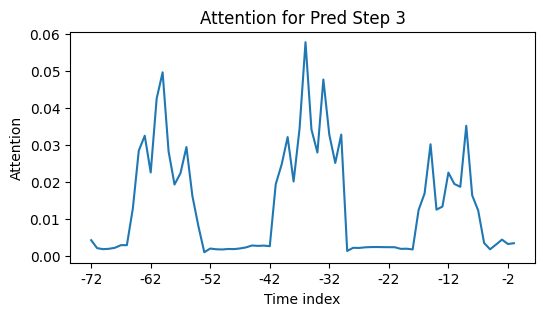

In [ ]:
# attention
fig, ax = plt.subplots()
attention = interpretation_none["attention"][pred_ind].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
ax.plot(attention)
ax.set_xlabel("Time index")
ax.set_ylabel("Attention")
ax.set_title(f"Attention for Pred Step {i}")
xticks_locations = range(0, len(attention), 10)
xticks_labels = range(-len(attention), 0, 10)
plt.xticks(xticks_locations, xticks_labels)
plt.show()

In [ ]:
# Pick one step, find the highest attention timestep, find 
pred_feat_importances = torch.mean(raw_predictions["encoder_variables"][pred_ind], dim=0)[0].numpy()

print(f"Prediction-Level Feature Importances at Pred Step {pred_ind}, across all encoder inds")
pred_feature_imp_dict = dict(zip(enc_var_names, pred_feat_importances))
sorted_dict = dict(sorted(pred_feature_imp_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

Prediction-Level Feature Importances at Pred Step 0, across all encoder inds
{'gap_flag_hour': 0.19956596, 'SW_IN_ERA': 0.17962879, 'NDVI': 0.1036113, 'BESS-RSDN': 0.08509452, 'NIRv': 0.0745492, 'hour': 0.06805203, 'VPD_ERA': 0.060291395, 'month': 0.05624755, 'TA_ERA': 0.04564881, 'PA_ERA': 0.045528546, 'gap_flag_month': 0.028593242, 'LW_IN_ERA': 0.020662371, 'P_ERA': 0.011690492, 'EVI': 0.010603456, 'relative_time_idx': 0.0102322865}


{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

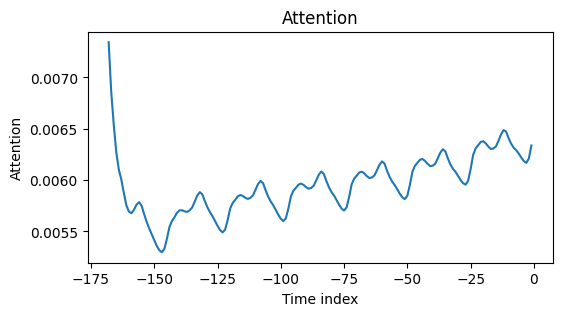

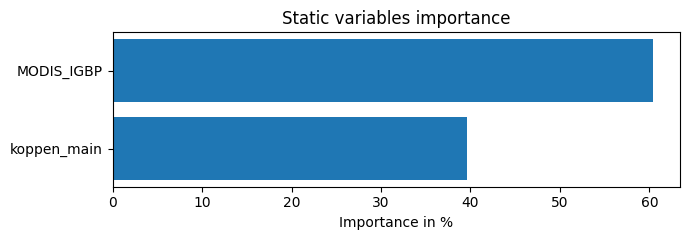

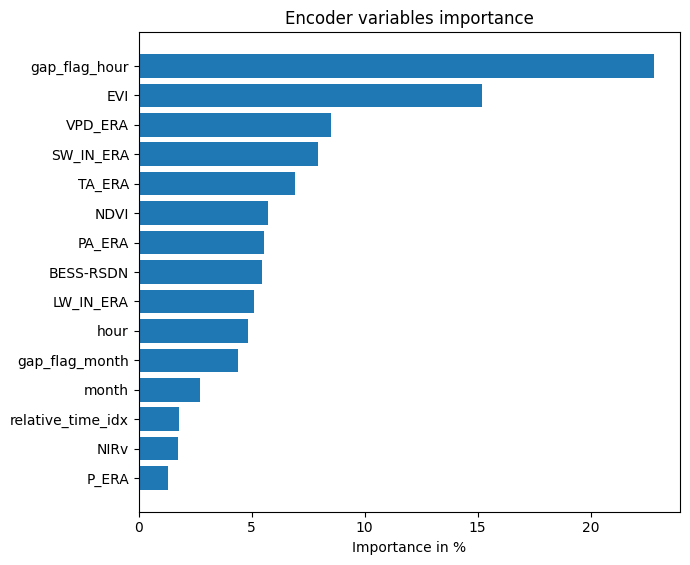

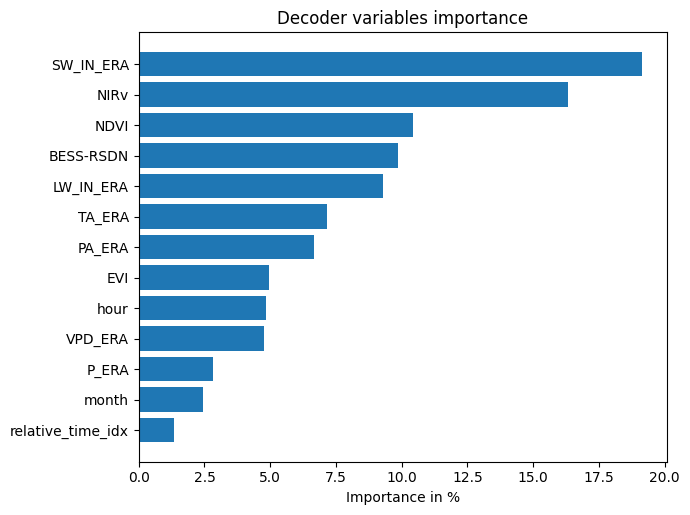

In [ ]:

# Interpret Outputs
interpretation_sum = best_tft.interpret_output(raw_prediction_igbp, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)

In [ ]:
# Init df
example_fi_df = pd.DataFrame(columns= ['encoder_timestep'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])

# Add avg importances to df
avg_fi_vals = torch.mean(torch.mean(raw_predictions["encoder_variables"].squeeze(), dim=0), dim=0).numpy()
example_fi_df.loc[len(example_fi_df)] = ['Average'] + list(avg_fi_vals)

# Get FIs at each step
for time in range(ENCODER_LEN):
    feature_means_time = torch.mean(raw_predictions["encoder_variables"].squeeze(), dim=0)[time].numpy()
    neg_time = time-ENCODER_LEN
    example_fi_df.loc[len(example_fi_df)] = [neg_time] + list(feature_means_time)

# Merge in attn vales
attn_time = torch.mean(raw_predictions["encoder_attention"].squeeze().squeeze(), dim=0)
example_fi_df['attn_time'] = [np.nan] + list(attn_time.numpy())

In [ ]:
#!conda install jinja2 -y

In [ ]:
# Save out
example_fi_df.to_csv(root_dir + os.sep + 'data/feature_imp_by_time_igbp_dbp.csv', index=False)

# Display
example_fi_df.sort_values('attn_time', ascending=False, inplace=True)
styled_df = example_fi_df.style.background_gradient(cmap='Greens')
styled_df

,encoder_timestep,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx,attn_time
1,-168.000000,0.030036,0.036695,0.063241,0.167284,0.101029,0.073588,0.058847,0.052201,0.051972,0.067458,0.122949,0.063858,0.045015,0.047376,0.018450,0.007589
2,-167.000000,0.030037,0.036694,0.063259,0.167420,0.100997,0.073601,0.058818,0.052191,0.051964,0.067401,0.122911,0.063845,0.044997,0.047405,0.018460,0.007306
3,-166.000000,0.030038,0.036694,0.063276,0.167557,0.100965,0.073613,0.058789,0.052180,0.051956,0.067344,0.122872,0.063832,0.044980,0.047433,0.018471,0.006843
4,-165.000000,0.030039,0.036693,0.063293,0.167693,0.100933,0.073626,0.058760,0.052170,0.051947,0.067287,0.122833,0.063819,0.044963,0.047462,0.018481,0.006437
157,-12.000000,0.030173,0.036469,0.065472,0.187805,0.095114,0.075361,0.054351,0.050591,0.050503,0.059494,0.116493,0.061924,0.042737,0.052620,0.020895,0.006197
158,-11.000000,0.030173,0.036466,0.065483,0.187929,0.095070,0.075371,0.054323,0.050581,0.050492,0.059448,0.116449,0.061913,0.042725,0.052659,0.020917,0.006188
156,-13.000000,0.030172,0.036471,0.065461,0.187681,0.095157,0.075350,0.054380,0.050601,0.050514,0.059539,0.116536,0.061935,0.042749,0.052580,0.020874,0.006175
168,-1.000000,0.030181,0.036440,0.065592,0.189151,0.094633,0.075472,0.054037,0.050478,0.050382,0.059008,0.116017,0.061803,0.042609,0.053056,0.021141,0.006157
159,-10.000000,0.030174,0.036463,0.065494,0.188053,0.095027,0.075381,0.054294,0.050570,0.050481,0.059403,0.116406,0.061903,0.042713,0.052698,0.020939,0.006154
5,-164.000000,0.030040,0.036693,0.063311,0.167829,0.100901,0.073638,0.058731,0.052160,0.051939,0.067230,0.122794,0.063806,0.044945,0.047491,0.018492,0.006143
